# Advanced Topics for Supervised Learning

In [17]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"



# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Challenges of Machine Learning: Bad Data - Imbalanced data

### Select and prepare data
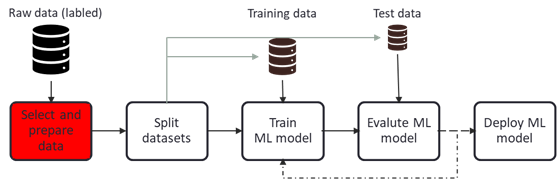

In [18]:
# Import libraries
import pandas as pd

# read the dataset
diabetes = pd.read_csv("https://raw.githubusercontent.com/VAWi-DataScience/Data-Science-and-Machine-Learning/main/Lecture/Data/diabetes.csv")

# Show top 5-records
diabetes.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [19]:
#Spliting dataset in two parts: feature set and target label
feature_set = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree','skin']
X = diabetes[feature_set]
y = diabetes.label

y.value_counts()

0    500
1    268
Name: label, dtype: int64

The dataset can be described as imbalanced, because we have 500 observations where the outcome is not present (i.e., 0) and 268 observations where the outcome is present (i.e., 1)

### Oversampling

In [20]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

ros = RandomOverSampler(random_state=0)
#rus = RandomUnderSampler(random_state=0) #Alternative for undersampling

X_oversampled, y_ovesampled = ros.fit_resample(X, y)
#X_oversampled, y_ovesampled = SMOTE().fit_resample(X, y) #Alternative for SMOTE

In [21]:
y_ovesampled.value_counts()

1    500
0    500
Name: label, dtype: int64

In this example, we use oversampling.

After applying oversampling, we have 500 observations for the presence and absence of the outcome

### Split dataset
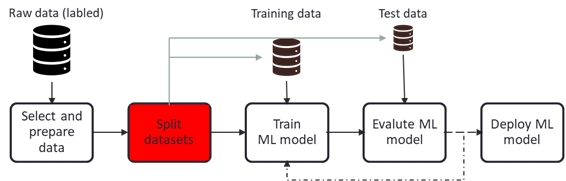

In [22]:
# Partition data into training and testing set
from sklearn.model_selection import train_test_split
X_train_OS,X_test_OS, y_train_OS, y_test_OS = train_test_split(X_oversampled, y_ovesampled, test_size=0.3, random_state=42)

### Train decicion tree model
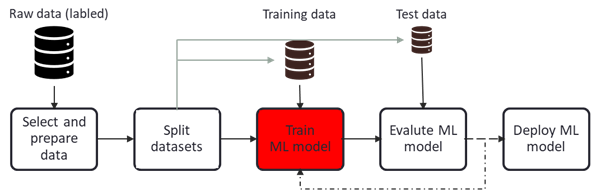

In [23]:
# Import Decision Tree model
from sklearn.tree import DecisionTreeClassifier
# Create a Decision Tree classifier object
clf_tree_OS = DecisionTreeClassifier(random_state=42, min_samples_leaf = 0.04)

# Train the model using training dataset
clf_tree_OS = clf_tree_OS.fit(X_train_OS,y_train_OS)

### Evaluate decision tree model (test data)
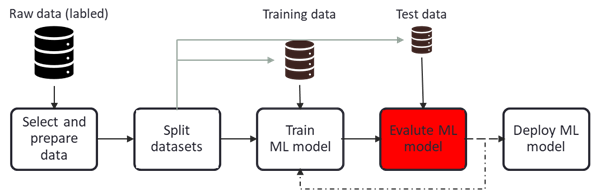

C:\Users\pknuhman\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


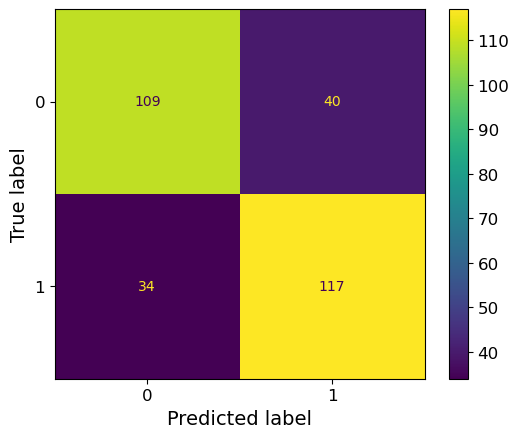

In [24]:
# Predict the response for test dataset
y_pred_test_OS = clf_tree_OS.predict(X_test_OS)

# Import the confusion matrix
from sklearn.metrics import plot_confusion_matrix

# Plot Confusion matrix
plot_confusion_matrix(clf_tree_OS , X_test_OS, y_test_OS, values_format='d')

In [25]:
# Oversampling
# Import metrics module for performance evaluation
from sklearn.metrics import accuracy_score

# Calculate model accuracy
print("Accuracy:",accuracy_score(y_test_OS, y_pred_test_OS))

Accuracy: 0.7533333333333333


The accuracy bevor oversampling was 0.71 (see chapter on decision trees).

The oversampling has improved the accuracy of the test data


## Cross-Validation

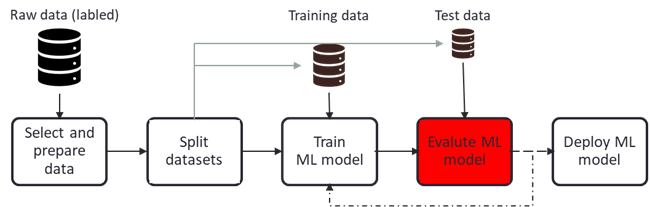

In [26]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf_tree_OS, X_train_OS,y_train_OS, scoring='accuracy')
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))
print("Standard deviation: {:.2f}".format(scores.std()))

Cross-validation scores: [0.76428571 0.73571429 0.77142857 0.70714286 0.77857143]
Average cross-validation score: 0.75
Standard deviation: 0.03


Using the mean cross-validation we can conclude that we expect the model to be around 75% accurate on average. Looking at all five scores produced by the five-fold cross-validation, we can also conclude that there is a relatively high variance in the accuracy between folds, ranging from 70% accuracy to 77% accuracy. 

This could imply that the model is very dependent on the particular folds used for training. 

In [27]:
#accuracy scores
y_pred_train_OS = clf_tree_OS.predict(X_train_OS)

print("Accuracy of training data:",accuracy_score(y_train_OS, y_pred_train_OS))
print("Accuracy of test data:",accuracy_score(y_test_OS, y_pred_test_OS))
print("Accuracy of cross-validation:", cross_val_score(clf_tree_OS, X_train_OS,y_train_OS,scoring='accuracy').mean())

Accuracy of training data: 0.7985714285714286
Accuracy of test data: 0.7533333333333333
Accuracy of cross-validation: 0.7514285714285714


The accuracy of the cross validation is wors than the performance of the training set, thus the model seems to suffer from high variance (i.e. overfitting).

# Hyperparameter Tuning

## Hyperparameter Tuning: Grid Search

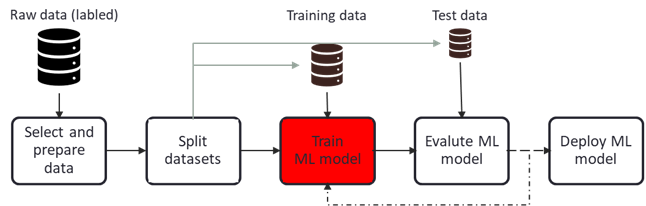

In [38]:
# show possible hyperparamter for classification trees
clf_tree_OS.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 0.04,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [39]:
from sklearn.model_selection import GridSearchCV

# Define the grid of hyperparameters
params_tree_clf = {
'max_depth': [1,2,3,4,5,6,7,8],
'min_samples_leaf': [0.0001,0.001,0.01,0.04, 0.06, 0.08, 0.1, 0.2],
'max_features': [0.2,0.4,0.6,0.8, 1],
'criterion' :['gini', 'entropy']
}

While the method of splitting the data into a training, a validation, and a test set that we just saw is workable, and relatively commonly used, it is quite sensitive to how exactly the data is split.

For a better estimate of the generalization performance, instead of using a single split into a training and a validation set, we can use cross-validation to evaluate the performance of each parameter combination.

Because grid search with cross-validation is such a commonly used method to adjust parameters, scikit-learn provides the GridSearchCV class, which implements it in the form of an estimator. To use the GridSearchCV class, you first need to specify the parameters you want to search over using a dictionary. GridSearchCV will then perform all the necessary model fits. The keys of the dictionary are the names of parameters we want to adjust and the values are the parameter settings we want to try out.

In [40]:
# Instantiate a 10-fold CV-grid search object
grid_clf_tree_OS = GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid=params_tree_clf,scoring='accuracy', cv=5,
n_jobs=-1)

# Fitd CV-grid search object to the training data
grid_clf_tree_OS.fit(X_train_OS,y_train_OS)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'max_features': [0.2, 0.4, 0.6, 0.8, 1],
                         'min_samples_leaf': [0.0001, 0.001, 0.01, 0.04, 0.06,
                                              0.08, 0.1, 0.2]},
             scoring='accuracy')

In [41]:
# Print the best hyperparameters 
print('Best hyerparameters:\n', grid_clf_tree_OS.best_params_)

Best hyerparameters:
 {'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.6, 'min_samples_leaf': 0.0001}


In [42]:
# Print the best CV score
print(grid_clf_tree_OS.best_score_)

0.8014285714285714


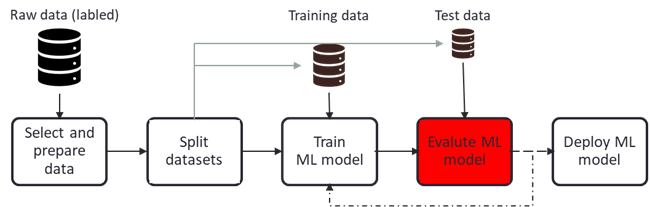

In [43]:
#Training the model according to the new parameter
clf_tree_OS_GS = DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=0.6, min_samples_leaf=0.0001, random_state=42)
clf_tree_OS_GS.fit(X_train_OS, y_train_OS)

#Accuracy scores
#train
print("Accuracy of training data:", accuracy_score(y_train_OS, clf_tree_OS_GS.predict(X_train_OS)))
#test
print("Accuracy of test data:",accuracy_score(y_test_OS, clf_tree_OS_GS.predict(X_test_OS)))
#CV
print("Accuracy of grid search cross-validation:", grid_clf_tree_OS.best_score_)

Accuracy of training data: 0.9128571428571428
Accuracy of test data: 0.7666666666666667
Accuracy of grid search cross-validation: 0.8014285714285714


## Deploying ML models

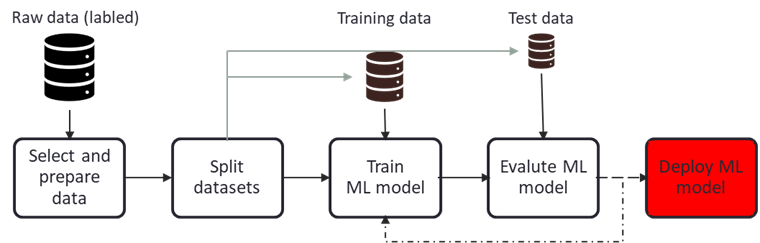

### Exporting

In [34]:
import joblib

In [35]:
joblib.dump(clf_tree_OS_GS, 'clf_tree_OS_GS.pkl')

['clf_tree_OS_GS.pkl']

### Importing

In [36]:
myImportedModel = joblib.load('clf_tree_OS_GS.pkl')

#### Using the imported model

In [37]:
print(myImportedModel.predict(X_test))

NameError: name 'X_test' is not defined